In [1]:
from process_bigraph import ProcessTypes, Composite, register_types
from process_bigraph.emitter import gather_emitter_results
from cobra.io import load_model
from vivaCRM.crm_gsmm_golford import (
    get_crm_goldford_emitter, 
    plot_crm_goldford_simulation)
from CRM.crm_gsmm_goldford_utils import ( 
    extract_yields, 
    extract_byproducts, 
    extract_uptake_rates, 
    run_mcrm_from_extractions, 
    plot_mcrm, 
    build_crm_goldford_config, 
    make_initial_state)
from vivaCRM.new_crm_gsmm_golford import build_params, MCRM_Process

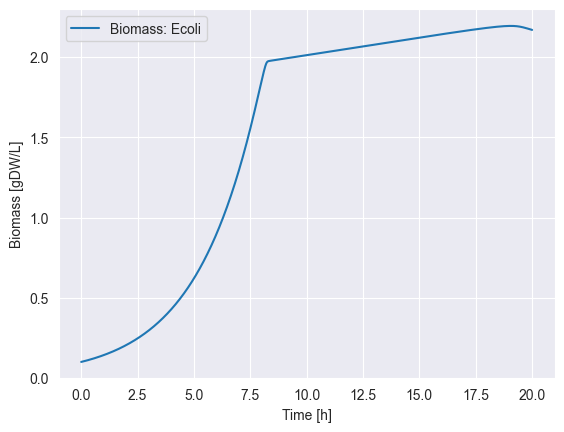

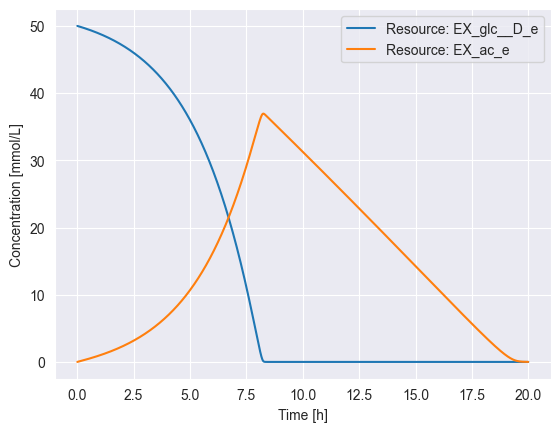

In [2]:
model = load_model("textbook")
resource_ids = ["EX_glc__D_e", "EX_ac_e"]  # choose resources to model

#Extract information from the gsmm file
extractions = {
    "Ecoli": {
        "yields": extract_yields(model, resource_ids, biomass_rxn_id="Biomass_Ecoli_core",
                                 uptake_cap=10.0, o2_lb=2.0, atpm_flux=1.0, use_pfba=False),
        "byproducts": extract_byproducts(model, resource_ids, biomass_rxn_id="Biomass_Ecoli_core",
                                         uptake_cap=10.0, o2_lb=2.0, atpm_flux=1.0, use_pfba=False),
        "uptakes": extract_uptake_rates(model, resource_ids, biomass_rxn_id="Biomass_Ecoli_core",
                                        uptake_cap=10.0, o2_lb=2.0, atpm_flux=1.0, use_pfba=False),
    }
}

# 2) Monod Km per resource
Km = {"EX_glc__D_e": 0.5, "EX_ac_e": 0.5}

# 3) Initial conditions (dicts)
n0 = {"Ecoli": 0.1}
R0 = {"EX_glc__D_e": 50.0, "EX_ac_e": 0.0}

# 4) Simulate
t, X, sp_order, res_order, params = run_mcrm_from_extractions(
    extractions, resource_ids, Km,
    initial_biomass_by_species=n0,
    initial_resources_by_id=R0,
    use_uptake_as_vmax=True,
    dilution=0.0,
    T=20.0, steps=1500,
)

# 5) Plot
plot_mcrm(t, X, sp_order, res_order)

# Vivarium implementation

In [3]:
model = load_model("textbook")
resource_ids = ["EX_glc__D_e", "EX_ac_e"]  # choose resources to model
extractions = {
    "Ecoli": {
        "yields": extract_yields(model, resource_ids, biomass_rxn_id="Biomass_Ecoli_core",
                                 uptake_cap=10.0, o2_lb=2.0, atpm_flux=1.0, use_pfba=False),
        "byproducts": extract_byproducts(model, resource_ids, biomass_rxn_id="Biomass_Ecoli_core",
                                         uptake_cap=10.0, o2_lb=2.0, atpm_flux=1.0, use_pfba=False),
        "uptakes": extract_uptake_rates(model, resource_ids, biomass_rxn_id="Biomass_Ecoli_core",
                                        uptake_cap=10.0, o2_lb=2.0, atpm_flux=1.0, use_pfba=False),
    }
}

# 2) Monod Km per resource
Km = {"EX_glc__D_e": 0.5, "EX_ac_e": 0.5}

# 2) build crm_goldford config
cfg = build_crm_goldford_config(extractions, resource_ids, Km,
                                maintenance_by_species={"Ecoli": 0.02},
                                dilution=0.0,
                                feed_by_resource={}, resource_loss_by_resource={})

# 3) initial state
state0 = make_initial_state(["Ecoli"], resource_ids,
                            n0_by_species={"Ecoli": 0.1},
                            R0_by_resource={"EX_glc__D_e": 50.0, "EX_ac_e": 0.0})

In [4]:
# build params
params = build_params(
    cfg['species_names'], cfg['resource_names'],
    yields_map=cfg['yields'],
    vmax_map=cfg['resource_uptakes'],
    maintenance_map=cfg['maintenance'],
    Km_map=cfg['Km'],
    byproducts_map=cfg['byproducts'],
    dilution=cfg['dilution'],
    feed_map=cfg['feed'],
    resource_loss_map=cfg['resource_loss'],
)

In [5]:
adaptive_spec = {
    "adaptive_crm": {
        "_type": "process",
        "address": "local:MCRM_Process",
        "config": {
            "species_names": cfg["species_names"],
            "resource_names": cfg["resource_names"],
            "params": params,
            "method": "RK45",
            "rtol": 1e-5, "atol": 1e-7, "max_step": 0.05,
            "clip_nonnegative": True,
        },
        "inputs": {"species": ["species"], "concentrations": ["concentrations"]},
        "outputs": {"species_delta": ["species"], "concentrations_delta": ["concentrations"]},
        "interval": 0.5,
    }
}

state0 = {
    "species": {"Ecoli": 0.1},
    "concentrations": {"EX_glc__D_e": 50.0, "EX_ac_e": 0.0},
    "global_time": 0.0,
}
spec = {**adaptive_spec, **state0}
state_keys = ["species", "concentrations", "global_time"]
spec["emitter"] = get_crm_goldford_emitter(state_keys)

In [6]:
core = ProcessTypes()
core = register_types(core)
core.register_process("MCRM_Process", MCRM_Process)
sim = Composite({"state": spec}, core=core)

In [7]:
params

MCRMParams(yields=array([[0.03646071, 0.01857921]]), vmax=array([[10.       ,  1.6836817]]), B=array([[[0.       , 0.       ],
        [0.9096579, 0.       ]]]), Km=array([0.5, 0.5]), maintenance=array([0.02]), dilution=0.0, feed=None, resource_loss=array([0., 0.]))

In [8]:
sim.run(20)

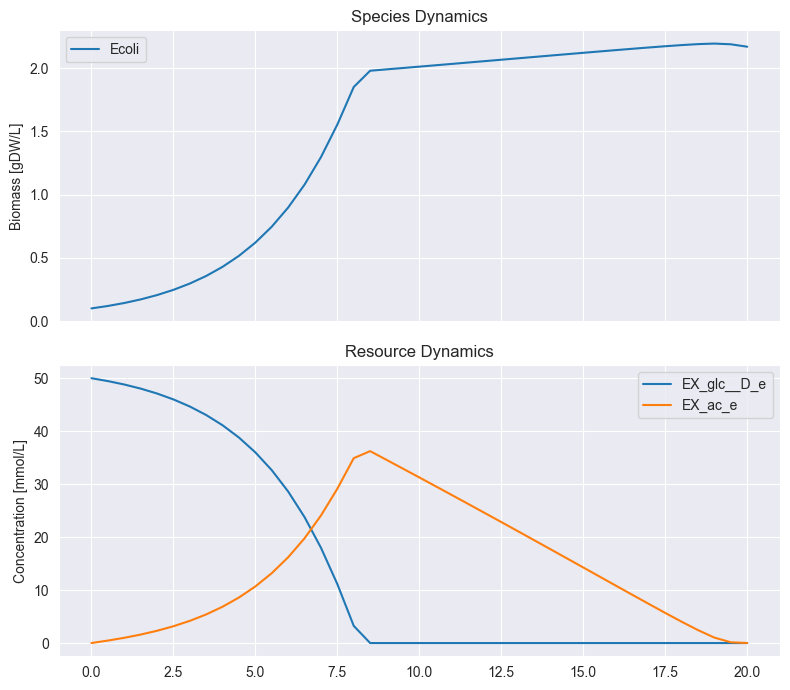

In [9]:
results = gather_emitter_results(sim)[('emitter',)]
plot_crm_goldford_simulation(results)

## To Do -  Implement this with multiple species and volumetric environment